In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, wandb, os, logging, json, random
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [51]:
path = '/data/jlai/dark_photon/BDT_input.csv'
df = pd.read_csv(path)
df = df[df.dphi_phterm_jetterm >= 1.80]
df = df[df.metsig <= 13]

Vars = [
    'metsig', 'metsigres', 'met', 'met_noJVT', 'dmet', 'ph_pt', 'ph_eta', 'ph_phi',
    'jet_central_eta', 'jet_central_pt1', 'jet_central_pt2', 'dphi_met_phterm', 'dphi_met_ph',
    'dphi_met_jetterm', 'dphi_phterm_jetterm', 'dphi_ph_centraljet1', 'metplusph', 'failJVT_jet_pt1',
    'softerm', 'jetterm', 'jetterm_sumet', 'dphi_met_central_jet', 'balance', 'dphi_jj', 'BDTScore'
]

Vars2 = [
    'metsig', 'met', 'met_noJVT', 'dmet', 'dphi_met_phterm','dphi_ph_centraljet1',
    'dphi_phterm_jetterm', 'jetterm', 'dphi_met_central_jet', 'BDTScore', 'weights', 'label',
]

Vars3 = [
    'metsigres', 'ph_pt', 'ph_eta', 'dphi_met_jetterm', 'failJVT_jet_pt1', 'n_jet_central', 'dphi_jj'
]

df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()
df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

Number of event with negative weights : 2977


,metsig,met,met_noJVT,dmet,dphi_met_phterm,dphi_ph_centraljet1,dphi_phterm_jetterm,jetterm,dphi_met_central_jet,BDTScore,weights,label,metsigres,ph_pt,ph_eta,dphi_met_jetterm,failJVT_jet_pt1,n_jet_central,dphi_jj
count,38492.000000,3.849200e+04,3.849200e+04,38492.000000,38492.000000,38447.000000,38492.000000,3.849200e+04,38447.000000,38492.000000,38492.000000,38492.000000,3.849200e+04,3.849200e+04,38492.000000,38492.000000,8483.000000,38452.000000,26817.000000
mean,9.991784,1.836330e+05,1.844361e+05,803.003707,1.999867,2.370942,2.392769,2.791821e+05,2.717955,0.268613,0.158478,0.052530,5.932411e-05,1.089405e-05,5.187550,3.031111,0.000039,0.576086,5.604123
std,1.617015,9.491743e+04,9.514334e+04,6106.780715,0.363279,0.420285,0.325857,2.200230e+05,0.280570,0.052894,0.811669,0.223097,1.521072e-05,4.875169e-06,154.120542,1.563456,0.000008,0.289799,192.132359
min,7.000263,1.000023e+05,8.257015e+04,-19999.797000,1.350051,0.029415,1.800161,7.222371e+04,0.055318,0.100074,0.000000,0.000000,7.169022e-07,2.580390e-07,0.571439,1.428635,0.000017,0.250000,0.400026
25%,8.681553,1.340742e+05,1.347810e+05,0.000000,1.704031,2.089095,2.127068,1.755567e+05,2.583422,0.237538,0.029029,0.000000,4.848526e-05,7.073552e-06,0.837438,1.995709,0.000034,0.333333,0.620245
50%,9.945528,1.666252e+05,1.673807e+05,0.000000,1.986191,2.381279,2.371883,2.287560e+05,2.751901,0.276320,0.070368,0.000000,6.037577e-05,1.100501e-05,1.251838,2.602243,0.000040,0.500000,1.069163
75%,11.328101,2.127410e+05,2.136554e+05,0.000000,2.269037,2.691011,2.648578,3.130785e+05,2.907944,0.307463,0.153261,0.000000,7.094846e-05,1.484530e-05,2.487716,3.573156,0.000045,1.000000,2.152461
max,12.999883,1.212000e+07,1.212000e+07,49947.516000,3.080134,3.141469,3.141593,4.394674e+06,3.141564,0.405219,111.573890,1.000000,9.552714e-05,1.999863e-05,29733.885000,35.942496,0.000050,1.000000,27594.105262


Number of nan in each variable: 
metsig                      0
met                         0
met_noJVT                   0
dmet                        0
dphi_met_phterm             0
dphi_ph_centraljet1        45
dphi_phterm_jetterm         0
jetterm                     0
dphi_met_central_jet       45
BDTScore                    0
weights                     0
label                       0
metsigres                   0
ph_pt                       0
ph_eta                      0
dphi_met_jetterm            0
failJVT_jet_pt1         30009
n_jet_central              40
dphi_jj                 11675
dtype: int64


In [44]:
print(sum(df_ml_input[df_ml_input.label==1]['weights']))
print(sum(df_ml_input[df_ml_input.label==0]['weights']))

204.67795916812304
5895.471038583419


random number:  64


Best parameters found: {'gamma': 0.23159853669629818, 'learning_rate': 0.09852788817383809, 'max_depth': 7, 'n_estimators': 468, 'subsample': 0.8476567711085726}


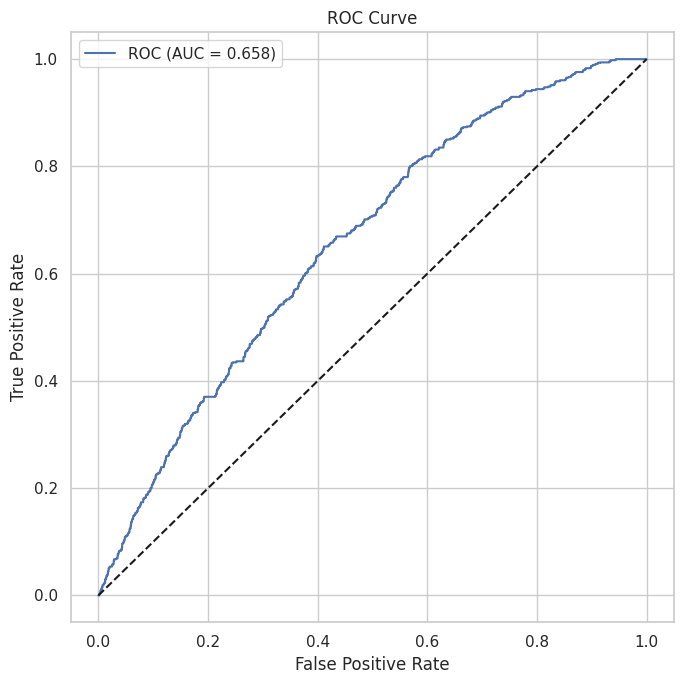

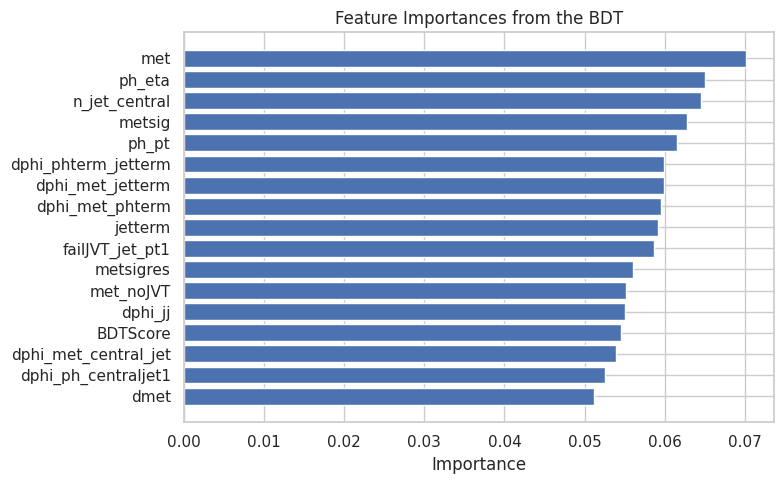

Best CV neg_log_loss,▁
Test Accuracy,▁
Test LogLoss,▁
Test ROC AUC,▁
Train Accuracy,▁
Train LogLoss,▁
Train ROC AUC,▁
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
test_auc,▁▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
test_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
test_logloss,█▆▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [03:32:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/jlai/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [03:32:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the de

In [54]:
# Define X (features) and y (labels)
X = df_ml_input.drop(['label', 'weights'], axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']
random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

wandb.init(project="Dark_ph BDT Random", reinit=True, resume=False)

param_distributions = {
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.8, 0.2),
    'gamma': uniform(0.1, 1),               # higher = more pruning
}

xgb_clf = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan,  # Let XGBoost handle any remaining NaNs
    random_state=random_num
)

random_search = RandomizedSearchCV(
    xgb_clf, param_distributions, n_iter=20, scoring='neg_log_loss', refit=True,
    cv=5, n_jobs=-1, random_state=random_num
)

random_search.fit(X_train, y_train,
          sample_weight=sw_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          sample_weight_eval_set=[sw_train, sw_test],
          verbose=False)

best_model = random_search.best_estimator_
wandb.config.update(random_search.best_params_)
wandb.log({"Best CV neg_log_loss": random_search.best_score_})
print("Best parameters found:", random_search.best_params_)

results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

for i, (train_l, test_l, train_e, test_e, train_a, test_a) in enumerate(zip(train_loss, test_loss, train_error, test_error, train_auc, test_auc)):
    wandb.log({
        "train_logloss": train_l,
        "test_logloss": test_l,
        "train_error": train_e,
        "test_error": test_e,
        "train_auc": train_a,
        "test_auc": test_a,
        "iteration": i
    })

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
    "Train LogLoss": log_loss(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test LogLoss": log_loss(y_test, y_test_pred_proba, sample_weight=sw_test),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test ROC AUC": roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
}

wandb.log(metrics)

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(metrics["Test ROC AUC"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_randomsearch.png")
wandb.log({"ROC Curve": wandb.Image("roc_randomsearch.png")})
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(['label', 'weights'], axis=1).columns

plt.figure(figsize=(8, 5))
plt.barh(range(len(selected_columns)), importances[indices], align='center')
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')
plt.tight_layout()
plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})
plt.show()

wandb.finish()